# ทำนายผลผลิตข้าวโดยใช้ผลผลิตปีก่อน ๆ ด้วย Prophet

https://facebook.github.io/prophet/docs/quick_start.html

In [1]:
import numpy as np
import pandas as pd
from fbprophet import Prophet

import plotly.offline as py
import plotly.graph_objs as go

from fbprophet.plot import plot_plotly, plot_components_plotly

from utils.preproc import read_yield, read_annually_data, read_month_data, add_regressor, is_harvest_season

py.init_notebook_mode(connected=True)

----
## Get Data

Read yield data

In [2]:
yield_in_season_file = 'OAE-process/OAE-ผลผลิตข้าวนาปี.xlsx'
area_in = 'Phayao'#'Ubon Ratchathani'
yield_off_season_file = 'OAE-process/OAE-ผลผลิตข้าวนาปรัง.xlsx'
area_off = 'Suphan Buri'

df_in, df_in_group, df_in_area = read_yield(yield_in_season_file, area_in)
df_off, df_off_group, df_off_area = read_yield(yield_off_season_file, area_off)

In [3]:
df_in_group[:30].sum() / df_in_group.sum()

value    0.80901
dtype: float64

In [4]:
df_in_group.head()

,value
area,
Ubon Ratchathani,5198810
Nakhon Sawan,5024792
Nakhon Ratchasima,4481451
Surin,4364261
Si Sa Ket,4151154


In [5]:
df_off_group.head()

,value
area,
Suphan Buri,2570861
Phra Nakhon Si Ayutthaya,2106367
Phitsanulok,1983621
Nakhon Sawan,1956327
Phichit,1903310


Show areas with the maximum yield in the last 5 years.

Get yield of one area.

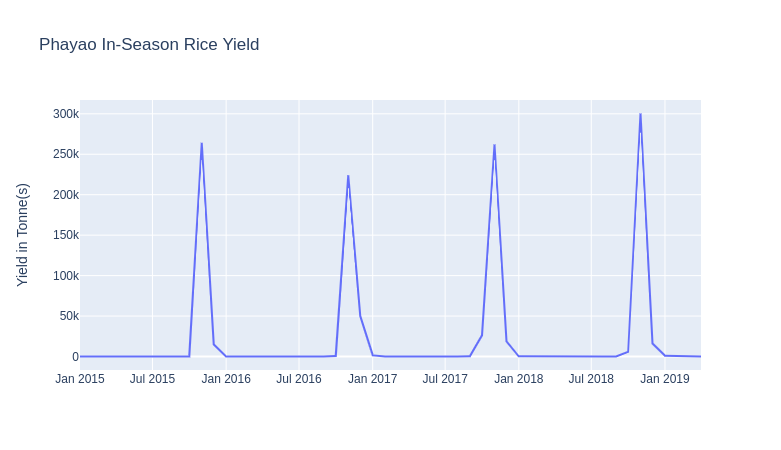

In [6]:
py.iplot({'data':go.Scatter(x=df_in_area['ds'], y=df_in_area['y'], name='y'),
         'layout':dict(title = area_in + ' In-Season Rice Yield',
                       yaxis = dict(title = 'Yield in Tonne(s)'))
         })

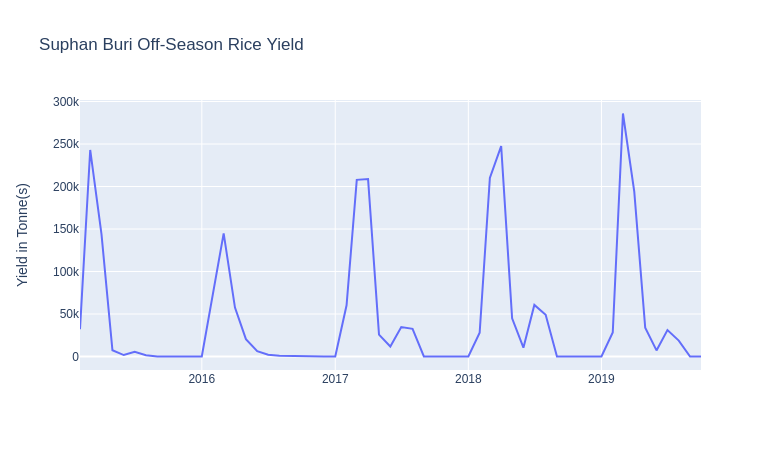

In [7]:
py.iplot({'data':go.Scatter(x=df_off_area['ds'], y=df_off_area['y'], name='y'),
         'layout':dict(title = area_off + ' Off-Season Rice Yield',
                       yaxis = dict(title = 'Yield in Tonne(s)'))
         })

In [8]:
cost_file = 'OAE-process/OAE-ต้นทุนรวมต่อไร่ข้าวนาปี.xlsx'
df_cost = read_annually_data(cost_file)
df_cost

,y
ds,
2020-12-01,4097.21
2020-11-01,4097.21
2020-10-01,4097.21
2020-09-01,4097.21
2020-08-01,4097.21
...,...
2015-05-01,4247.31
2015-04-01,4247.31
2015-03-01,4247.31


In [9]:
precipitation_file = 'OAE-process/OAE-ปริมาณน้ำฝน-ฝนตก.xlsx'
df_in_precip = read_month_data(precipitation_file, area_in)
df_in_precip

,y
ds,
2020-12-01,19.49
2020-11-01,52.91
2020-10-01,142.63
2020-09-01,171.63
2020-08-01,193.26
...,...
2015-05-01,96.10
2015-04-01,67.50
2015-03-01,43.42


In [10]:
rainday_file = 'OAE-process/OAE-ปริมาณน้ำฝน-จำนวนวันฝนตก.xlsx'
df_in_rainday = read_month_data(rainday_file, area_in)
df_in_rainday

,y
ds,
2020-12-01,2.8
2020-11-01,4.7
2020-10-01,11.5
2020-09-01,16.4
2020-08-01,18.7
...,...
2015-05-01,11.0
2015-04-01,8.0
2015-03-01,3.0


In [11]:
price_file = 'OAE-process/OAE-ราคาข้าวเปลือกเจ้า.xlsx'
df_in_price = read_month_data(price_file)
df_in_price

,y
ds,
2020-07-01,8941
2020-06-01,9052
2020-05-01,9319
2020-04-01,9453
2020-03-01,8655
...,...
2015-05-01,7674
2015-04-01,7607
2015-03-01,7723


In [12]:
df_train, df_test = df_in_area[12:], df_in_area[:12]

In [13]:
@add_regressor(df_in_price, 'price')
# @add_regressor(df_in_rainday, 'rainday')
@add_regressor(df_in_precip, 'precipitation')
@add_regressor(df_cost, 'cost')
def add_features(df):
    return df

----

## Model 1: Prophet default parameters

In [14]:
df_train, df_test = df_in_area[12:], df_in_area[:12]

In [15]:
model = Prophet(seasonality_prior_scale=0.05)
model.fit(df_train)
future = model.make_future_dataframe(periods=24, freq="MS")
forecast = model.predict(future)
forecast.yhat.clip(lower=0, inplace=True)
forecast = forecast.sort_values(by='ds', ascending=False).reset_index().drop(columns=['index'])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [16]:
# Sanity check that we are evaluating the forecase at the same date
assert(np.all(forecast[12:24]['ds'].to_numpy() == df_test['ds'].to_numpy()))
# Calculate root mean squared error.
print('RMSE: %f' % np.sqrt(np.mean((forecast[12:24]['yhat'].to_numpy() - df_test['y'].to_numpy())**2)) )

RMSE: 14877.792817


In [17]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-04-01,27367.948046,-6994.891163,11534.296733,27342.486044,27397.686356,-24697.197107,-24697.197107,-24697.197107,-24697.197107,-24697.197107,-24697.197107,0.0,0.0,0.0,2670.750939
1,2020-03-01,27295.010004,-6206.437837,11092.747887,27270.886163,27323.105153,-24974.743919,-24974.743919,-24974.743919,-24974.743919,-24974.743919,-24974.743919,0.0,0.0,0.0,2320.266086
2,2020-02-01,27226.777643,-4811.397950,12652.612712,27204.259854,27253.111660,-23199.725160,-23199.725160,-23199.725160,-23199.725160,-23199.725160,-23199.725160,0.0,0.0,0.0,4027.052484
3,2020-01-01,27153.839602,-6032.939003,11611.313299,27133.210229,27178.009625,-23994.707824,-23994.707824,-23994.707824,-23994.707824,-23994.707824,-23994.707824,0.0,0.0,0.0,3159.131777
4,2019-12-01,27080.901560,16874.088057,34945.846552,27061.830453,27103.293522,-1148.186876,-1148.186876,-1148.186876,-1148.186876,-1148.186876,-1148.186876,0.0,0.0,0.0,25932.714684


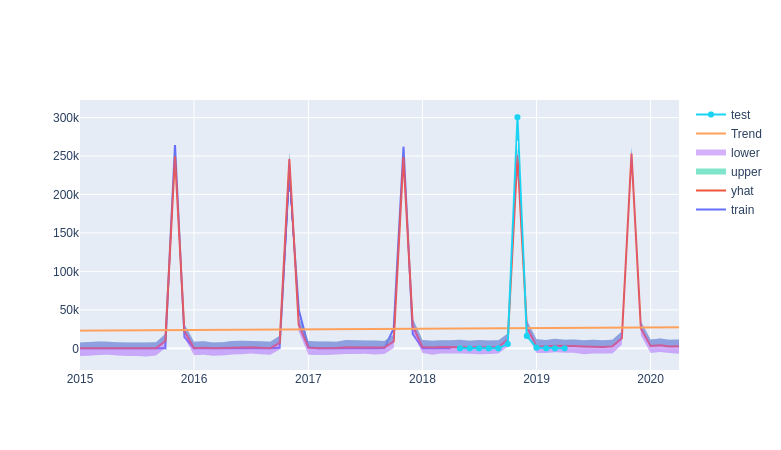

In [18]:
py.iplot([
    go.Scatter(x=df_train['ds'], y=df_train['y'], name='train'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend'),
    go.Scatter(x=df_test['ds'], y=df_test['y'], name='test'),
])

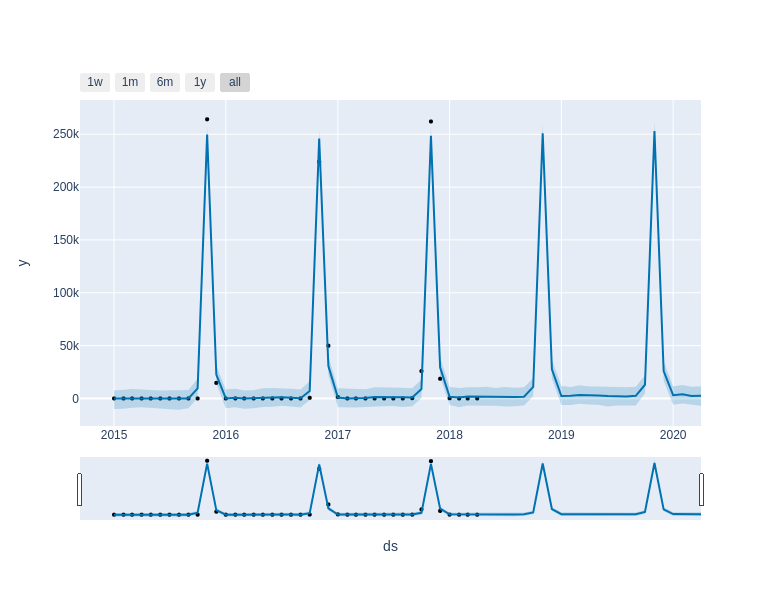

In [19]:
plot_plotly(model, forecast)

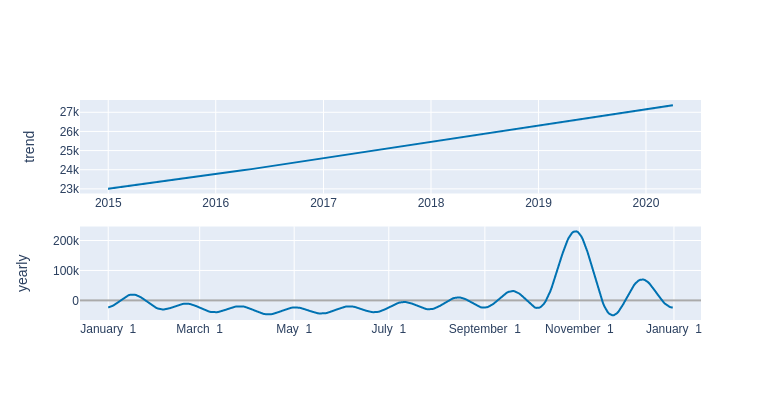

In [20]:
plot_components_plotly(model, forecast)

----

## Model 2: Prophet default parameters with harvesting season

In [21]:
df_train, df_test = df_in_area[12:], df_in_area[:12]

In [22]:
df_train = df_train.apply(is_harvest_season, axis=1)

In [23]:
model = Prophet(seasonality_prior_scale=0.1)
model.add_seasonality(name='monthly_harvest_season', period=30.5, fourier_order=5, condition_name='harvest_season')
model.fit(df_train)

future = model.make_future_dataframe(periods=24, freq="MS")
future = future.apply(is_harvest_season, axis=1)

forecast = model.predict(future)
forecast.yhat.clip(lower=0, inplace=True)
forecast = forecast.sort_values(by='ds', ascending=False).reset_index().drop(columns=['index'])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
future

,ds,harvest_season
0,2015-01-01,False
1,2015-02-01,False
2,2015-03-01,False
3,2015-04-01,False
4,2015-05-01,False
...,...,...
59,2019-12-01,True
60,2020-01-01,False
61,2020-02-01,False
62,2020-03-01,False


In [25]:
# Sanity check that we are evaluating the forecase at the same date
assert(np.all(forecast[12:24]['ds'].to_numpy() == df_test['ds'].to_numpy()))
# Calculate root mean squared error.
print('RMSE: %f' % np.sqrt(np.mean((forecast[12:24]['yhat'].to_numpy() - df_test['y'].to_numpy())**2)) )

RMSE: 13588.049349


In [26]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly_harvest_season,monthly_harvest_season_lower,monthly_harvest_season_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-04-01,10095.795208,-7191.192111,5296.009626,10095.768637,10095.821430,-10891.623808,-10891.623808,-10891.623808,0.000000,0.000000,0.000000,-10891.623808,-10891.623808,-10891.623808,0.0,0.0,0.0,0.000000
1,2020-03-01,10099.232646,-7362.117637,4731.007591,10099.207914,10099.257139,-11176.761810,-11176.761810,-11176.761810,0.000000,0.000000,0.000000,-11176.761810,-11176.761810,-11176.761810,0.0,0.0,0.0,0.000000
2,2020-02-01,10102.448313,-5646.993914,7056.139776,10102.424791,10102.471015,-9456.645259,-9456.645259,-9456.645259,0.000000,0.000000,0.000000,-9456.645259,-9456.645259,-9456.645259,0.0,0.0,0.0,645.803054
3,2020-01-01,10105.885750,-6061.647653,6267.154990,10105.863541,10105.906997,-9891.573992,-9891.573992,-9891.573992,0.000000,0.000000,0.000000,-9891.573992,-9891.573992,-9891.573992,0.0,0.0,0.0,214.311759
4,2019-12-01,10109.323188,-48577.225436,-35618.220858,10109.302344,10109.342989,-52041.302016,-52041.302016,-52041.302016,1568.394157,1568.394157,1568.394157,-53609.696172,-53609.696172,-53609.696172,0.0,0.0,0.0,0.000000


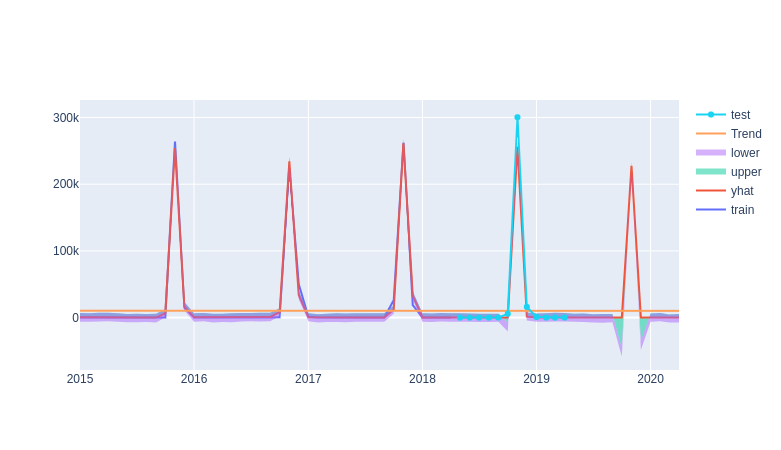

In [27]:
py.iplot([
    go.Scatter(x=df_train['ds'], y=df_train['y'], name='train'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend'),
    go.Scatter(x=df_test['ds'], y=df_test['y'], name='test'),
])

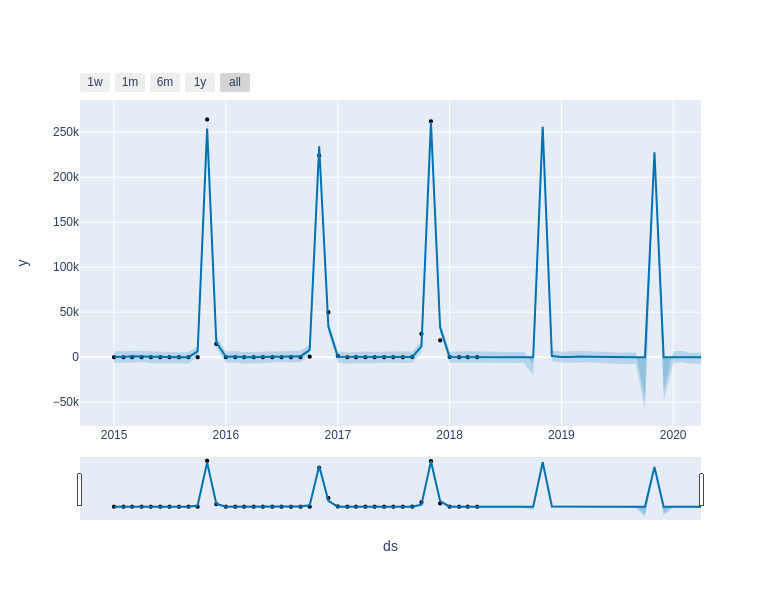

In [28]:
plot_plotly(model, forecast)

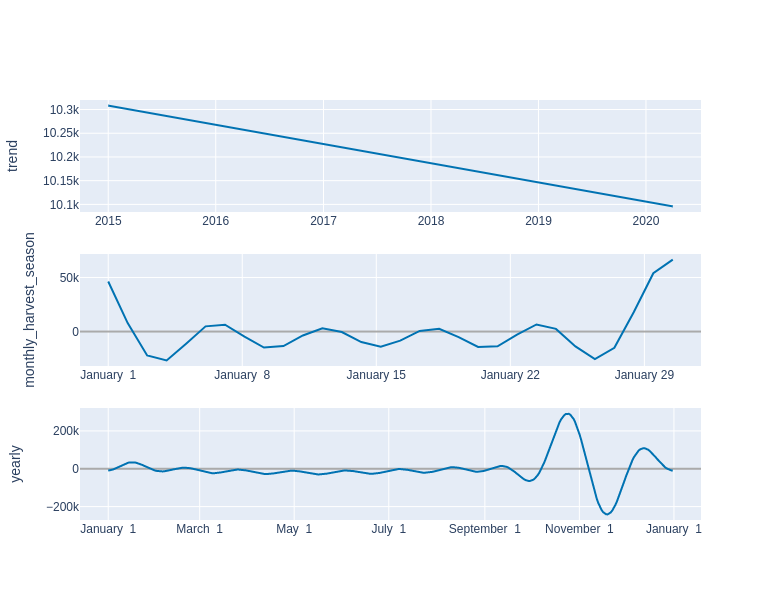

In [29]:
plot_components_plotly(model, forecast)

----

## Model 3: Prophet default parameters with harvesting and external regressors

In [30]:
df_train, df_test = df_in_area[12:], df_in_area[:12]

In [31]:
df_train = add_features(df_train)
df_train = df_train.apply(is_harvest_season, axis=1)

In [32]:
df_train.head()

,ds,y,cost,precipitation,price,harvest_season
12,2018-04-01,0,3991.22,200.60,7838,False
13,2018-03-01,0,3991.22,32.50,7635,False
14,2018-02-01,0,3991.22,2.20,7609,False
15,2018-01-01,233,3991.22,7.90,7804,False
16,2017-12-01,18671,3870.27,61.61,8223,True


In [33]:
model = Prophet(seasonality_prior_scale=0.1, holidays_prior_scale=10)
model.add_seasonality(name='monthly_harvest_season', period=30.5, fourier_order=5, condition_name='harvest_season')
for col in ['cost', 'precipitation', 'price']:
    model.add_regressor(col, prior_scale=5, mode='multiplicative')

model.fit(df_train)

future = model.make_future_dataframe(periods=24, freq="MS")
future = add_features(future)
future = future.apply(is_harvest_season, axis=1)

forecast = model.predict(future)
forecast.yhat.clip(lower=0, inplace=True)
forecast = forecast.sort_values(by='ds', ascending=False).reset_index().drop(columns=['index'])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
# Sanity check that we are evaluating the forecase at the same date
assert(np.all(forecast[12:24]['ds'].to_numpy() == df_test['ds'].to_numpy()))
# Calculate root mean squared error.
print('RMSE: %f' % np.sqrt(np.mean((forecast[12:24]['yhat'].to_numpy() - df_test['y'].to_numpy())**2)) )

RMSE: 12996.143244


In [35]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,cost,...,precipitation,precipitation_lower,precipitation_upper,price,price_lower,price_upper,yearly,yearly_lower,yearly_upper,yhat
0,2020-04-01,12045.970281,-17683.209810,-6438.686234,12044.916815,12047.051503,-12889.646136,-12889.646136,-12889.646136,0.003680,...,0.016137,0.016137,0.016137,-0.947928,-0.947928,-0.947928,-12889.646136,-12889.646136,-12889.646136,0.000000
1,2020-03-01,12023.891831,-12284.590545,-754.299105,12022.906691,12024.896176,-14064.282111,-14064.282111,-14064.282111,0.003680,...,0.101301,0.101301,0.101301,-0.492813,-0.492813,-0.492813,-14064.282111,-14064.282111,-14064.282111,0.000000
2,2020-02-01,12003.237798,-6592.677074,4646.332924,12002.310780,12004.185218,-12297.625447,-12297.625447,-12297.625447,0.003680,...,0.148029,0.148029,0.148029,-0.213927,-0.213927,-0.213927,-12297.625447,-12297.625447,-12297.625447,0.000000
3,2020-01-01,11981.159348,-4474.331857,6554.863918,11980.284677,11982.032865,-12289.790202,-12289.790202,-12289.790202,0.003680,...,0.093466,0.093466,0.093466,0.019904,0.019904,0.019904,-12289.790202,-12289.790202,-12289.790202,1093.764752
4,2019-12-01,11959.080898,-46419.713798,-35218.230417,11958.271968,11959.887488,-54794.410204,-54794.410204,-54794.410204,-0.006546,...,0.119149,0.119149,0.119149,0.048990,0.048990,0.048990,-55891.355653,-55891.355653,-55891.355653,0.000000


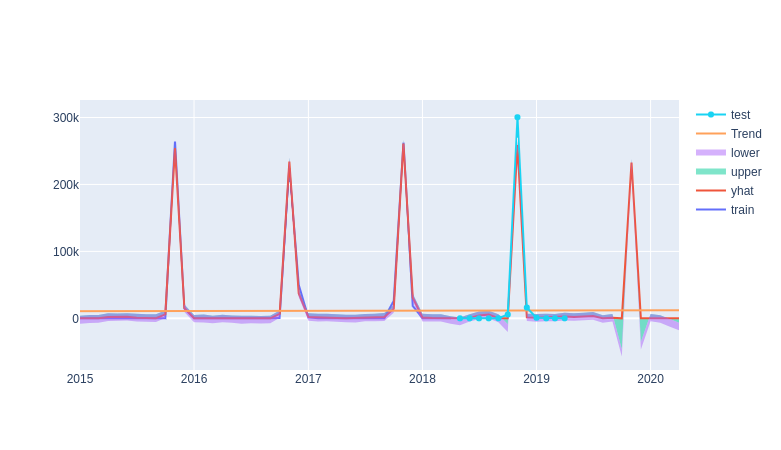

In [36]:
py.iplot([
    go.Scatter(x=df_train['ds'], y=df_train['y'], name='train'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend'),
    go.Scatter(x=df_test['ds'], y=df_test['y'], name='test'),
])

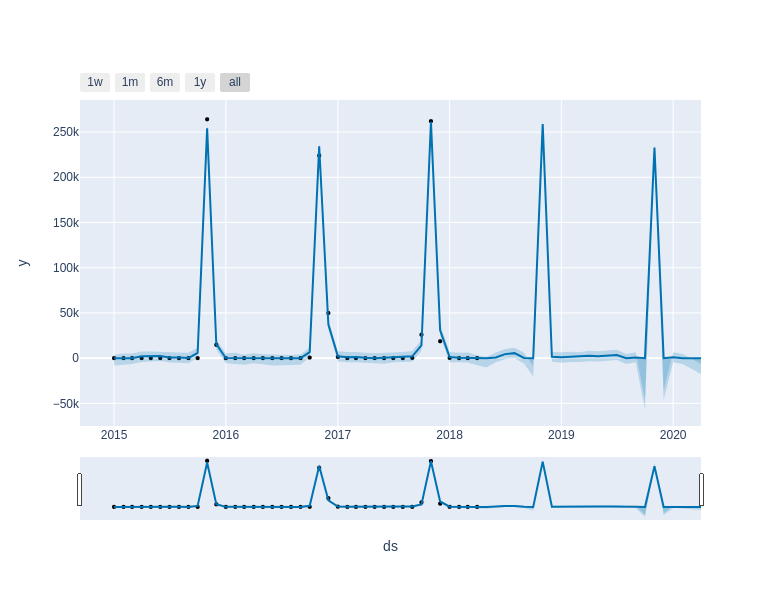

In [37]:
plot_plotly(model, forecast)

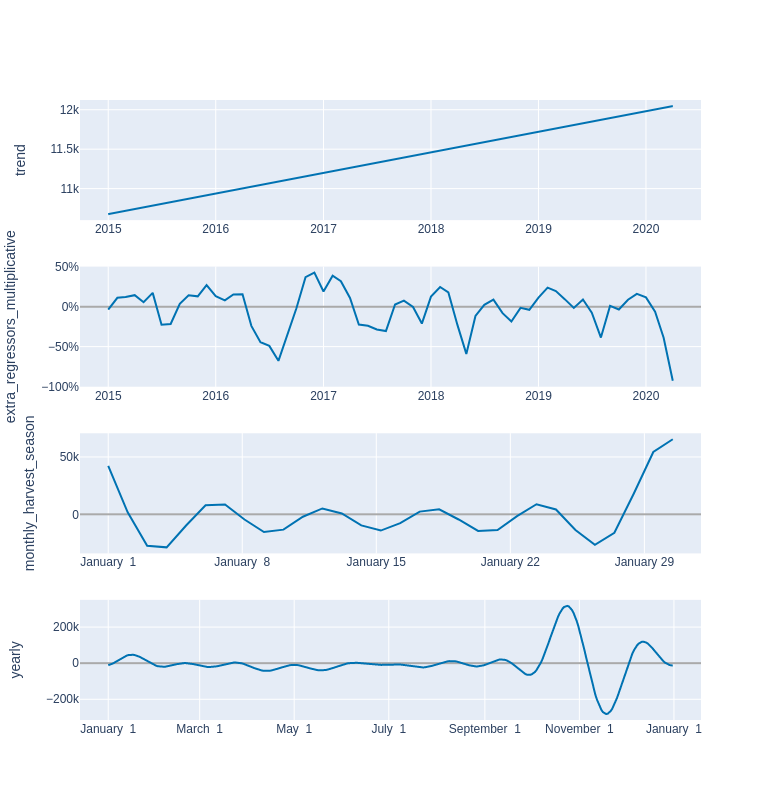

In [38]:
plot_components_plotly(model, forecast)